# Second model: convolutions
## Data augmentation, learning rate decay, dropout.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf
print("done loading libraries")

done loading libraries


## Loading data

Paths to datasets.

In [3]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '\data\\train.csv'
print(FTRAIN)
FTEST = FROOT + '\data\\test.csv'
print(FTEST)
#FLOOKUP = FROOT + '/data/IdLookupTable.csv'
Irows=640
Icols=480

D:\FYP\CNN\muct-master\allimger\data\train.csv
D:\FYP\CNN\muct-master\allimger\data\test.csv


In [4]:
def scaley(y,rows,cols):
	#loop for rows
	dr=cols/2
	for i in range(0,152,2):
		y[:,i]=y[:,i]/dr
	#loop for cols
	dc=rows/2
	for i in range(1,152,2):
		y[:,i]=y[:,i]/dc
	return y

def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test     : optional, defaults to `False`
               Flag indicating if we need to load from `FTEST` (`True`) or FTRAIN (`False`)
    cols     : optional, defaults to `None`
               A list of columns you're interested in. If specified only returns these columns.
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['image'] = df['image'].apply(lambda im: np.fromstring(im, sep = ','))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[4:-1]].values
        y = scaley(y,640,480)   #(y - 48) / 48   scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [5]:
def plot_sample(x, y, axis):
    """
    Plots a single sample image with keypoints on top.
    
    Parameters
    ----------
    x     : 
            Image data.
    y     : 
            Keypoints to plot.
    axis  :
            Plot over which to draw the sample.   
    """
    img = x.reshape(Irows, Icols)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 240 + 240, y[1::2] * 320 + 320, marker='x', s=10)

In [6]:
num_channels = 1 # grayscale
image_size = 96

def load2d(test = False, cols = None):
    X, y = load(test = test)
    X = X.reshape(-1, Irows, Icols, num_channels)
    return X, y

Load the training dataset.

In [7]:
X, y = load2d()
print("done loading traing dataset")

Index     1689
name      1689
f_name    1689
f_loc     1689
x00       1689
y00       1689
x01       1689
y01       1689
x02       1689
y02       1689
x03       1689
y03       1689
x04       1689
y04       1689
x05       1689
y05       1689
x06       1689
y06       1689
x07       1689
y07       1689
x08       1689
y08       1689
x09       1689
y09       1689
x10       1689
y10       1689
x11       1689
y11       1689
x12       1689
y12       1689
          ... 
y61       1689
x62       1689
y62       1689
x63       1689
y63       1689
x64       1689
y64       1689
x65       1689
y65       1689
x66       1689
y66       1689
x67       1689
y67       1689
x68       1689
y68       1689
x69       1689
y69       1689
x70       1689
y70       1689
x71       1689
y71       1689
x72       1689
y72       1689
x73       1689
y73       1689
x74       1689
y74       1689
x75       1689
y75       1689
image     1689
Length: 157, dtype: int64
done loading traing dataset


Split the initial training dataset into training, validation and testing datasets.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)
print("done spliting")

done spliting


This is our data augmentation routine. It randomly flips a defined portion of dataset horizontally.

In [9]:

class FlipBatchIterator(BatchIterator):
    """
    Batch iterator that randomly flips a defined portion of dataset horizontally.
    """
    
    flip_indices = [
        (0,28),(1,29),(2,26),(3,27),(4,24),
        (5,25),(6,22),(7,23),(8,20),(9,21),
        (10,18),(11,19),(12,16),(13,17),(30,42),
        (31,43),(32,44),(33,45),(34,46),(35,47),
        (36,48),(37,49),(38,50),(39,51),(40,52),
        (41,53),(54,64),(55,65),(56,66),(57,67),
        (58,68),(59,69),(60,70),(61,71),(62,72),
        (63,73),(74,90),(75,91),(76,88),(77,89),
        (78,86),(79,87),(80,84),(81,85),(92,94),
        (93,95),(96,108),(97,109),(98,106),(99,107),
        (100,104),(101,105),(110,118),(111,119),
        (112,116),(113,117),(120,124),(121,125),
        (126,130),(127,131),(136,144),(137,145),
        (138,146),(139,147),(140,148),(141,149),
        (142,150),(143,151)
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

Try flipping a sample batch of images and plot it to verify it's all good. What you should see is half of images flipped.

In [10]:
batch_iterator = FlipBatchIterator(batch_size = 10)
for x_batch, y_batch in batch_iterator(X.copy(), y.copy()):
    for i in range(1):        
        # plot two images:
        fig = pyplot.figure(figsize=(6, 3))
        ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        plot_sample(X[i], y[i], ax)
        ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        plot_sample(x_batch[i], y_batch[i], ax)
        pyplot.show()
    break
print("done line 10")

done line 10


## Parameters

In [11]:
# Predefined parameters
num_keypoints = 152
batch_size = 36
num_epochs = 1001

data_augmentation = True
learning_rate_decay = True
momentum_increase = True
dropout = True

# We will encode model settings in its name: architecture, batch size, number of epochs and optimisations applied.
model_name = "MUCTmodel"+"_3con_2fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
if data_augmentation:
    model_name += "_aug"
if learning_rate_decay:
    model_name += "_lrdec"
if momentum_increase:
    model_name += "_mominc"
if dropout:
    model_name += "_dr"
    
model_variable_scope = model_name
root_location = FROOT + "/models/"
model_path = root_location + model_name + "/model.ckpt"
train_history_path = root_location + model_name + "/train_history"

os.makedirs(root_location + model_name + "/", exist_ok = True)

## Routines

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [12]:
def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.
    
    Parameters
    ----------
    input  : 
            Input tensor for calculating layer shape.
    size   : 
            Layer size, e.g. number of units.
               
    Returns
    -------
    A graph variable calculating single fully connected layer.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    """
    Creates a fully connected TensorFlow layer with ReLU non-linearity applied.
    """
    return tf.nn.relu(fully_connected(input, size))

Routine for a single convolution layer pass.

In [13]:
def conv_relu(input, kernel_size, depth):
    """
    Creates a convolutional TensorFlow layer followed by a ReLU.
    
    Parameters
    ----------
    input         : 
                    Input tensor for calculating layer shape.
    kernel_rsize   : 
                    Kernel row size.
    kernel_csize   : 
                    Kernel column size.
    depth         : 
                    Layer depth, e.g. number of units.
               
    Returns
    -------
    A graph variable calculating convolutional layer with applied ReLU.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer=tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

Routine for a pooling layer.

In [14]:
def pool(input, size):
    """
    Performs max pooling.
    
    Parameters
    ----------
    input  : 
            Input tensor.
    rsize   : 
            Pooling kernel row size.
    csize   : 
            Pooling kernel  column size.
               
    Returns
    -------
    A graph variable calculating single max pooling layer.
    """
    return tf.nn.max_pool(
        input, 
        ksize=[1, size, size, 1], 
        strides=[1, size, size, 1], 
        padding='SAME'
    )

Routine that performs entire model pass, e.g. returns model prediction for given input with current model (3 convolution layers with 2 fully connected layers):

In [15]:
def model_pass(input, training):
    """
    Performs a whole model pass.
    
    Parameters
    ----------
    input     : 
                Input tensor to be passed through the model.
    training  : 
                Tensorflow flag indicating if we are training or evaluating our model 
                (so that we know if we should apply dropout).
               
    Returns
    -------
    Model prediction.
    """
    # Convolutional layers
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = 3, depth = 32) 
        pool1 = pool(conv1, size = 2)
        # Apply dropout if needed
        pool1 = tf.cond(training, lambda: tf.nn.dropout(pool1, keep_prob = 0.9 if dropout else 1.0), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
        pool2 = pool(conv2, size = 2)
        # Apply dropout if needed
        pool2 = tf.cond(training, lambda: tf.nn.dropout(pool2, keep_prob = 0.8 if dropout else 1.0), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
        pool3 = pool(conv3, size = 2)
        # Apply dropout if needed
        pool3 = tf.cond(training, lambda: tf.nn.dropout(pool3, keep_prob = 0.7 if dropout else 1.0), lambda: pool3)
    
    # Flatten convolutional layers output
    shape = pool3.get_shape().as_list()
    flattened = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # Fully connected layers
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = 1000)
        # Apply dropout if needed
        fc4 = tf.cond(training, lambda: tf.nn.dropout(fc4, keep_prob = 0.5 if dropout else 1.0), lambda: fc4)
    with tf.variable_scope('fc5'):
        fc5 = fully_connected_relu(fc4, size = 1000)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc5, size = num_keypoints)
    return prediction

Calculates loss based on model predictions.

In [16]:
def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.
    
    Parameters
    ----------
    predictions : ndarray 
                  Predictions.
    labels      : ndarray
                  Actual values.
               
    Returns
    -------
    Squared mean error for given predictions.
    """
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [17]:
def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.
    
    Parameters
    ----------
    start :  
            Time starting point.
               
    Returns
    -------
    Nicely formatted time difference between now and `start`.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [18]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, Irows, Icols, num_channels))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))
    is_training = tf.placeholder(tf.bool)

    current_epoch = tf.Variable(0)  # count the number of epochs

    # Model parameters.
    
    # Calculate learning rate decay if needed.
    if learning_rate_decay:
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps=num_epochs, decay_rate=0.03)
    else:
        learning_rate = 0.01
        
    # Calculate increasing momentum if needed.
    if momentum_increase:
        m_min = 0.9
        m_max = 0.99
        momentum = m_min + (m_max - m_min) * (current_epoch / num_epochs) 
    else:
        momentum = 0.9
    
    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = model_pass(tf_x_batch, is_training)
    
    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch,
                is_training : False
            }
        )
        p.extend(p_batch)
    return p

In [ ]:
start = time.time()
every_epoch_to_log = 5

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    train_loss_history = np.zeros(num_epochs)
    valid_loss_history = np.zeros(num_epochs)
    print("============ TRAINING =============")
    for epoch in range(num_epochs):
        current_epoch = epoch
        # Train on whole randomised dataset in batches
        batch_iterator = FlipBatchIterator(batch_size = batch_size, shuffle = True) if data_augmentation else BatchIterator(batch_size = batch_size, shuffle = True)
        for x_batch, y_batch in batch_iterator(x_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch, 
                    tf_y_batch : y_batch,
                    is_training : True
                }
            )

        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_loss = calc_loss(
                get_predictions_in_batches(x_train, session), 
                y_train
            )
            train_loss_history[epoch] = train_loss

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, session), 
                y_valid
            )
            valid_loss_history[epoch] = valid_loss
            
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("     Train loss: %.8f" % (train_loss))
                print("Validation loss: %.8f" % (valid_loss))
                print("           Time: " + get_time_hhmmss(start))

    # Evaluate on test dataset.
    test_loss = calc_loss(
        get_predictions_in_batches(x_test, session), 
        y_test
    )
    print("===================================")
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
    print("Train history file: " + train_history_path)

============ TRAINING =============


## Evaluation

In [21]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(model = model_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots history of learning curves for a specific model based on the saved training history. 
    You may want to call `pyplot.show()` afterwards.
    
    Parameters
    ----------
    model             : optional, defaults to current model name
                        Model name.
    linewidth         : optional, defaults to 2
                        Line thickness.
    train_linestyle   : optional, defaults to "b-"
                        Matplotlib line style for the training curve.
    valid_linestyle   : optional, defaults to "g-"
                        Matplotlib line style for the validation curve.
               
    Returns
    -------
    Number of epochs plotted.
    """
    model_history = np.load(root_location + model + "/train_history.npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label=model + " train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label=model + " valid")
    return epochs

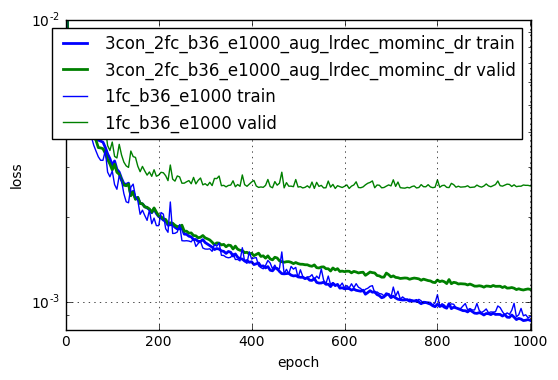

In [24]:
new_model_epochs = plot_learning_curves()
old_model_epochs = plot_learning_curves("1fc_b36_e1000", linewidth = 1)

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0008, 0.01)
pyplot.xlim(0, max(new_model_epochs, old_model_epochs))
pyplot.yscale("log")
pyplot.show()